Example Script Associated with:
# Speed of sound of pure water to 700 MPa and an equation of state to 2300 MPa
## by O. Bollengier, J.M. Brown, and G. Shaw

The following demonstrates the use of a "Local Basis Function" (LBF) representation for the Gibbs energy equation of state of water.   

Units: MPa for pressure, K for temperature, S.I. units for density, Cp, and G (kg, J, m)

To run the notebook, 

*  Install [the LocalBasisFunction repository](https://github.com/jmichaelb/LocalBasisFunction/tree/master/Python) code and its dependencies.  Among the optional dependencies mentioned, [Jupyter](https://jupyter.readthedocs.io/en/latest/install.html) and [matplotlib](https://matplotlib.org/users/installing.html) are both required for this script.
   * Note: If your system has both Python 2 and Python 3 installed, you may encounter import errors when running the notebook.  This likely indicates that jupyter is using the Python2 kernel.  To fix this, in the console, run command
```python3 -m ipykernel install --user```, then restart the notebook.
*  Download the following files in [SoundSpeedOfPureWater_2019](https://github.com/jmichaelb/PublicationArchive/tree/master/SoundSpeedOfPureWater_2019).  Code in the notebook assumes the directory structure indicated here.
   * ```G_H2O_2GPa_500K.mat```
   * ```Python/DemoScript.ipynb```
   * ```Python/IAPWS_sp_strct.mat```
*  In a console (e.g. Terminal in OSX), navigate to the Python folder and enter command ```jupyter notebook```.  
*  Click on ```DemoScript.ipynb```.  
*  Each individual code block  can be executed by clicking the play icon to the left of the block, or by using the Run button at the top. Comments in the code are preceded by a hash.
* When you are finished running the notebook, close the notebook using File/Close and Halt.  Then return to the console and close the window, electing to terminate processes.  Alternately, use ```Ctrl+C``` to stop the process, then answer ```y``` when asked whether you should shut down the notebook server.  See the [Jupyter docs](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/execute.html) for more detail.



### 1. Load data into the environment and describe the content

The LBF is stored as a struct in a MATLAB data file, with the range of coverage incorporated into the name.  This struct is loaded into the Python environment as a dictionary, using only those elements needed for evaluation of the spline.  The contents of the spline are then shown. 

Keys in the dictionary match the standard element names used by MATLAB representations of tensor splines. See [MATLAB documentation](https://www.mathworks.com/help/curvefit/multivariate-tensor-product-splines.html) for more information.  

In [1]:
import numpy as np

from mlbspline import load
from lbftd import statevars, loadGibbs as lg, evalGibbs as eg

G_H2O_2GPa_500K = load.loadSpline('../G_H2O_2GPa_500K.mat')
G_H2O_2GPa_500K

{'form': 'B-',
 'knots': array([array([   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,   15.        ,   20.        ,
          25.        ,   30.        ,   35.        ,   40.        ,
          45.        ,   50.        ,   55.        ,   60.        ,
          65.        ,   70.        ,   75.        ,   80.        ,
          85.        ,   90.        ,   95.09172249,  100.33476036,
         105.79195946,  111.52959614,  117.61756454,  124.03785154,
         130.80859712,  137.94893146,  145.47902897,  153.42016533,
         161.79477754,  170.62652738,  179.94036821,  189.76261551,
         200.12102122,  211.04485216,  222.56497269,  234.71393195,
         247.52605581,  261.03754386,  275.28657167,  290.31339869,
         306.16048195,  322.87259607,  340.49695973,  359.08336909,
         378.6843385 ,  399.35524887,  421.15450412,  444.14369622,
         468.38777922,  493.95525276,  520.91835557,  549.35326967,
         579.3403

### Extract thermodynamic properties from the LBF representation

The thermodynamic variables (tdvs) currently supported for pure substances are listed below.  For each tuple, the first value is what would be passed to the evaluation function to limit which variables are calculated.  The second value is merely descriptive.

In [2]:
[(sv.name, sv.calcFn.__name__[4:]) for sv in statevars.tdvsPTOnly]

[('G', 'GibbsEnergy'),
 ('U', 'InternalEnergy'),
 ('H', 'HelmholtzEnergy'),
 ('S', 'Entropy'),
 ('rho', 'Density'),
 ('V', 'Volume'),
 ('Cp', 'IsobaricSpecificHeat'),
 ('Cv', 'IsochoricSpecificHeat'),
 ('Kt', 'IsothermalBulkModulus'),
 ('Kp', 'PDerivIsothermalBulkModulus'),
 ('Ks', 'IsentropicBulkModulus'),
 ('vel', 'SoundSpeed'),
 ('alpha', 'ThermalExpansivity')]

#### Calculating thermodynamic properties for scattered data points

To calculate thermodynamic variables (tdvs) for scattered pressures and temperatures, basic syntax is

    out_scatter = eg.evalSolutionGibbsScatter(gibbsSp, PTM, *tdvSpec)
    
where 
* ```gibbsSp``` is a Gibbs energy LBF with dimensions pressure (MPa) and temperature (K), in the order defined by ```statevars.iP``` and ```statevars.iT```, respectively. 
* ```PTM``` is a Numpy ndarray of tuples with the points at which ```gibbsSp``` should be evaluated. The number of elements in each tuple must be same as in the spline (```PTM[0].size == gibbsSp['number'].size```).  Each tuple gives the pressure (P) and temperature (T) in the same order and units as in the ```gibbsSp``` parameter.  No sorting is required.
* ```tdvSpec``` is an optional list of the tdvs to be calculated.  If no values are provided, this function will calculate all supported tdvs as listed above.  Requesting an unsupported value will result in an error; note that values are case-sensitive.  See [the LocalBasisFunction source code repository](https://github.com/jmichaelb/LocalBasisFunction/tree/master/Python) for units of each tdv.

The output of the function call is an object with the requested thermodynamic variables as named properties matching those requested in the ```*tdvSpec``` parameter (all supported values if no list of values provided). The object also includes a ```PTM``` property that contains a copy of the input ```PTM``` parameter.

The following code block calculates all supported properties at STP.

In [4]:
print({'pressure_index': statevars.iP, 'temp_index': statevars.iT})
PTM = np.empty((1,), np.object)
PTM[0] = (0.1, 300)  # pressure = 0.1 MPa, temperature = 300 K
out_single = eg.evalSolutionGibbsScatter(G_H2O_2GPa_500K, PTM)
vars(out_single) # Note: this does not include the PTM attribute.

{'pressure_index': 0, 'temp_index': 1}


{'G': array([-5267.28216317]),
 'U': array([112549.08139637]),
 'H': array([-5367.62771417]),
 'S': array([393.05569704]),
 'rho': array([996.5563895]),
 'V': array([0.00100346]),
 'Cp': array([4180.59628951]),
 'Cv': array([4130.12907247]),
 'Kt': array([2220.20941558]),
 'Kp': array([5.57619587]),
 'Ks': array([2247.33878332]),
 'vel': array([1501.700531]),
 'alpha': array([0.00027479])}

For comparison, here is the same information calculated from an LBF based on IAPWS-95.  See [doi:10.1016/j.fluid.2018.02.001](https://doi.org/10.1016/j.fluid.2018.02.001) for details on the differences between this and the actual IAPWS 95 values.

In [5]:
iapws_sp = load.loadSpline('./IAPWS_sp_strct.mat')
iapws_out = eg.evalSolutionGibbsScatter(iapws_sp, PTM)
vars(iapws_out)

{'G': array([-5265.19521713]),
 'U': array([112556.37101179]),
 'H': array([-5365.54077318]),
 'S': array([393.07303928]),
 'rho': array([996.5563392]),
 'V': array([0.00100346]),
 'Cp': array([4180.75236869]),
 'Cv': array([4130.2900946]),
 'Kt': array([2219.74045413]),
 'Kp': array([5.70772829]),
 'Ks': array([2246.86037759]),
 'vel': array([1501.54072197]),
 'alpha': array([0.0002748])}

Thermodynamic variables can also be calculated for multiple scattered data points.  Here we calculate density for five states:

| Pressure (MPa) | Temperature (K) |
| --------------:| ---------------:|
|       441.0858 |        313.9500 |
|       478.7415 |        313.9600 |
|       444.8285 |        313.7800 |
|       459.1574 |        313.8000 |
|      485.4930  |        313.8200 |

Each thermodynamic variable in the output contains an array with indices corresponding to those in the input ```PTM``` parameter.  

In [6]:
PTM = np.empty((5,), np.object)
PTM[0] = (441.0858, 313.9500)
PTM[1] = (478.7415, 313.9600)
PTM[2] = (444.8285, 313.7800)
PTM[3] = (459.1574, 313.8000)
PTM[4] = (485.4930, 313.8200)
out_scatter = eg.evalSolutionGibbsScatter(G_H2O_2GPa_500K, PTM, 'rho') # calculate just one of the tdvs
out_scatter.rho

array([1128.21830415, 1136.65424508, 1129.1580671 , 1132.38514694,
       1138.20701159])

#### Calculating and plotting thermodynamic properties for gridded data points

To calculate thermodynamic variables (tdvs) for a grid of pressures and temperatures, basic syntax is

    output = eg.evalSolutionGibbsGrid(gibbsSp, PTM, *tdvSpec)

where the ```gibbsSp``` and ```tdvSpec``` parameters are the same as in ```evalSolutionGibbsScatter```, but the ```PTM``` parameter has a different format.  Here, ```PTM``` is a Numpy ndarray of ndarrays with the conditions at which ```gibbsSp``` should be evaluated. The number of dimensions must be same as in the spline (```PTM.size == gibbsSp['number'].size```), with the first inner array giving a list of pressures and the second a list of temperatures at which thermodynamic variables should be calculated, as dictated by ```statevars.iP``` and ```statevars.iT```.  Each inner array must be sorted from low to high values, and be expressed in the units indicated in the ```gibbsSp``` parameter. 

The output of the function call is an object with the requested thermodynamic variables as named properties matching those requested in the ```*tdvSpec``` parameter.  The output also includes a ```PTM``` property so that the regime for each is easily passed along with the calculated values.  

The call below calculates a subset of supported thermodynamic variables: 
* density (rho)
* isobaric specific heat (Cp)
* isothermal bulk modulus (Kt)
* thermal expansivity (alpha)
* sound speed (vel)

Note that only requested values will be included in the output.

In [7]:
P = np.arange(0.1, 1000.2, 10)  # pressures from 0.1 - 1000.1 MPa
T = np.arange(240, 501, 2)      # temperatures from 240 - 500 K
out_grid = eg.evalSolutionGibbsGrid(G_H2O_2GPa_500K, np.array([P, T]), 'rho', 'Cp', 'Kt', 'alpha', 'vel')
vars(out_grid).keys()

dict_keys(['rho', 'Cp', 'Kt', 'vel', 'alpha'])

Output values can be addressed using object/property syntax.  Output for each thermodynamic variable (tdv) is a matrix, with the first index corresponding to a pressure in ```out_grid.PTM[statevars.iP]``` and the second corresponding to a temperature in ```out_grid.PTM[statevars.iT]```.

In [8]:
pi = np.random.randint(0,out_grid.PTM[statevars.iP].size) # index of a random pressure at which tdvs were evaluated
ti = np.random.randint(0,out_grid.PTM[statevars.iT].size) # index of a random temperature at which tdvs were evaluated 
"P={:.4f} MPa, T={:.4f} K, density={:.1f} kg/m^3".format(
    out_grid.PTM[statevars.iP][pi], out_grid.PTM[statevars.iT][ti], out_grid.rho[pi,ti])

'P=350.1000 MPa, T=340.0000 K, density=1093.2 kg/m^3'

### Graph output

One complication that arises is that equations of state often fail in the metastable regimes, and calculated thermodynamic variables in such regimes should be ignored. 

Here, representative points along the solid-liquid phase boundary are used with linear interpolation to estimate a melt temperature for each pressure used in the call to ```evalSolutionGibbsGrid```.   For conditions where pressures are greater than 200 MPa and temperatures are less than 30 K into the metastable region (as determined by the linear interpolation of the melt line), calculated thermodynamic variables will be masked.

In [9]:
# each tuple in the meltPts list is a (P, T) point on water's solid/liquid phase boundary
meltPts = [(519.434280948267, 267.344), (729.115053826038, 281.330), 
           (1011.718732632325, 300.970), (1311.325816361429, 317.720000000000), 
           (1767.779620830581, 338.370), (2662.848259920574, 389.060),
           (3067.817595662678, 416.940), (3430.677955656706, 439.340), 
           (3568.975836584907, 447.240), (5818.528900637745, 537.090)]
meltP, meltT = zip(*meltPts)
estMeltT = np.interp(P, meltP, meltT)    # interpolate melt temps for each pressure used to eval thermodynamic vars

# build function that will mask values for pressures > 200 MPa and temps more than 30 K below the pressure melt temp
mask = np.array([[np.nan if p > 200 and t < mt - 30 else 1 for t in T] for p, mt in zip(P, estMeltT)])
masked = lambda z: np.ma.masked_where(np.isnan(mask), z)

The output can be visualized using a wide range of packages available in Python.  Here, we use the [matplotlib](https://matplotlib.org/) library to plot the output.

To graph, first prepare a grid of pressure and temperature values, then set up the figure and plot a surface corresponding to the masked thermodynamic variable.

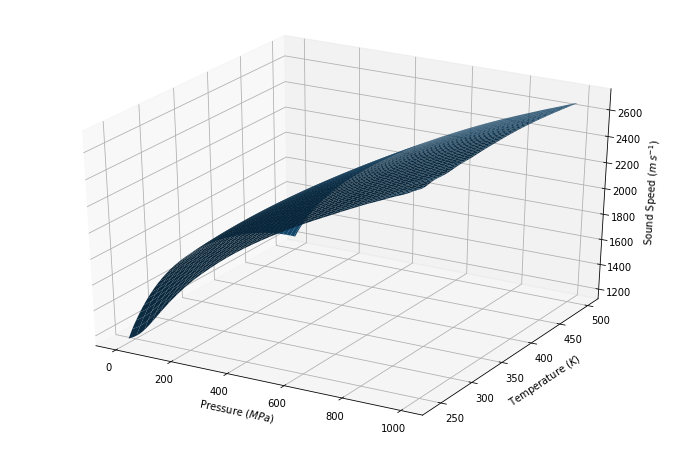

In [10]:
pT, pP = np.meshgrid(T, P) 

import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
rcParams['axes.labelpad'] = 7                 # add some padding to prevent axis labels from covering ticks
rcParams['figure.figsize'] = [12, 8]          # increase default size of figure

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('Pressure ($MPa$)')
ax.set_ylabel('Temperature ($K$)')
ax.set_zlabel('Sound Speed ($m\: s^{-1}$)');  # you can use LaTex coding in labels
vel_surf = ax.plot_surface(pP, pT, masked(out_grid.vel))    
ax.invert_yaxis()

Matplotlib also allows creation of a figure with subplots.

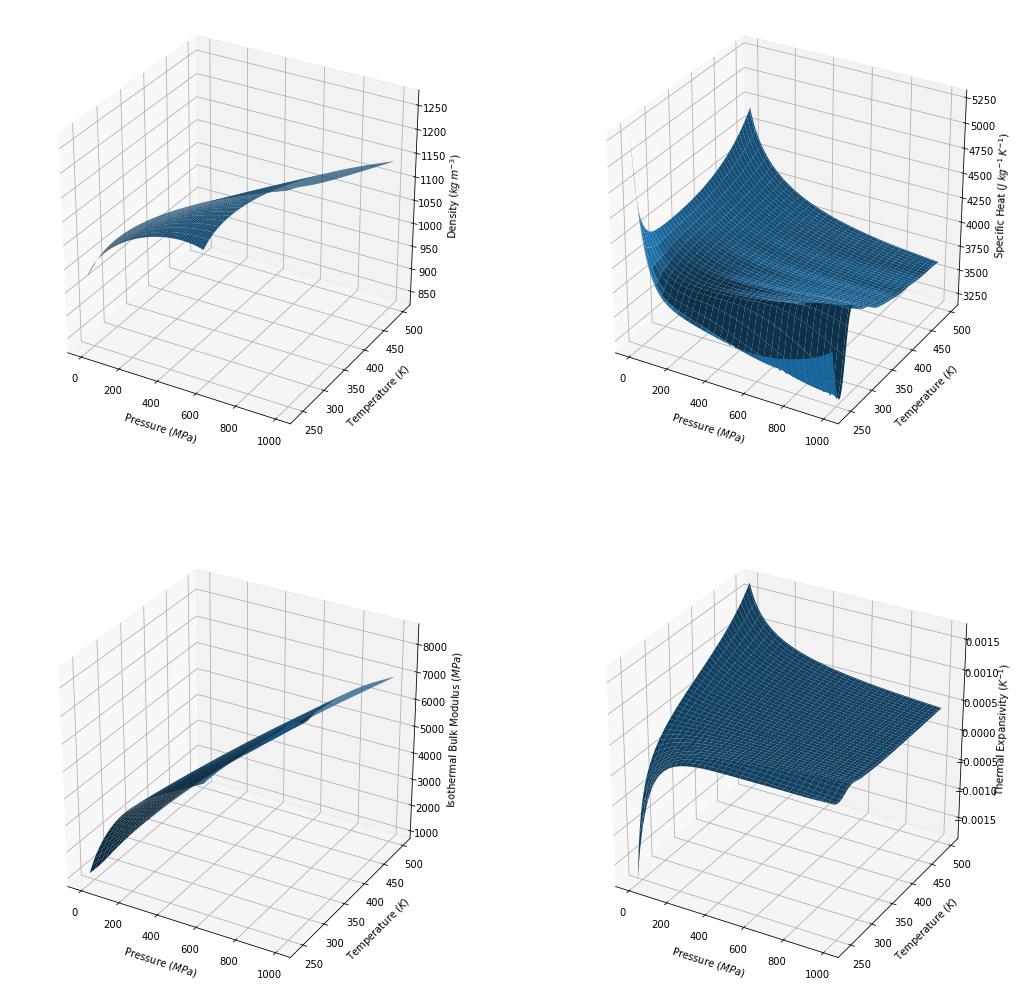

In [11]:
rcParams['figure.figsize'] = [18, 18]
fig2 = plt.figure()
rho_ax = fig2.add_subplot(221, projection='3d')
rho_ax.set_xlabel('Pressure ($MPa$)')
rho_ax.set_ylabel('Temperature ($K$)')
rho_ax.set_zlabel('Density ($kg\: m^{-3}$)')  
rho_surf = rho_ax.plot_surface(pP, pT, masked(out_grid.rho))
rho_ax.invert_yaxis()

cp_ax = fig2.add_subplot(222, projection='3d')
cp_ax.set_xlabel('Pressure ($MPa$)')
cp_ax.set_ylabel('Temperature ($K$)')
cp_ax.set_zlabel('Specific Heat ($J\: kg^{-1}\: K^{-1}$)')
cp_surf = cp_ax.plot_surface(pP, pT, masked(out_grid.Cp))
cp_ax.invert_yaxis()

kt_ax = fig2.add_subplot(223, projection='3d')
kt_ax.set_xlabel('Pressure ($MPa$)')
kt_ax.set_ylabel('Temperature ($K$)')
kt_ax.set_zlabel('Isothermal Bulk Modulus ($MPa$)')
kt_surf = kt_ax.plot_surface(pP, pT, masked(out_grid.Kt))
kt_ax.invert_yaxis()

alpha_ax = fig2.add_subplot(224, projection='3d')
alpha_ax.set_xlabel('Pressure ($MPa$)')
alpha_ax.set_ylabel('Temperature ($K$)')
alpha_ax.set_zlabel('Thermal Expansivity ($K^{-1}$)')
alpha_surf = alpha_ax.plot_surface(pP, pT, masked(out_grid.alpha))
alpha_ax.invert_yaxis()